- neural network - audioData 2

In [1]:
import numpy as np
import tensorflow.keras as keras
import keras.layers as layers
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import soundfile as sf

Add path to util-functions

In [2]:
import sys
sys.path.append('D:/1. Studium/7. Semester/BA/Birdvoice/utils')

The Paths to the OD-databases

In [3]:
databasePathsParusMajor=['../../../dataPreprocessing/databases/od/ParusMajor/ParusMajorSongOD1.csv', '../../../dataPreprocessing/databases/od/ParusMajor/ParusMajorSongOD5.csv']
databasePathsTurdusMerula=['../../../dataPreprocessing/databases/od/TurdusMerula/TurdusMerulaSongOD5.csv']
databasePathsCorvusCorone=['../../../dataPreprocessing/databases/od/CorvusCorone/CorvusCoroneCallOD5.csv']

Load data from chosen path

In [4]:
sampleCount = 2000

x_train = pd.read_csv(databasePathsCorvusCorone[0], header=None, delimiter=',', index_col=None, nrows=sampleCount).to_numpy()
_, AUDIO_COLS = x_train.shape
print(x_train.shape)

(2000, 55125)


Generator

In [5]:
def buildGenerator():
    model = keras.models.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape=(AUDIO_COLS)))
    
    model.add(keras.layers.Dense(256))

    model.add(keras.layers.Dense(512))

    model.add(keras.layers.Dense(1024))

    model.add(keras.layers.Dense(AUDIO_COLS, activation="tanh"))
              
    return model

Discriminator

In [6]:
def buildDiscriminator():
    model = keras.models.Sequential()
    
    model.add(keras.layers.InputLayer(AUDIO_COLS))
    
    model.add(keras.layers.Dense(512))
    
    model.add(keras.layers.Dense(256))

    model.add(keras.layers.Dense(1, activation="sigmoid"))

    return model

Train function

In [7]:
def train(iterations, batch_size=64):
    
    valid = np.ones(batch_size)
    generated = np.zeros(batch_size)
    
    for i in range(iterations):
        #select audios from data
        indices = np.random.randint(0, len(x_train), batch_size)
        audios = x_train[indices]
        
        #get fake audio from generator
        noise = np.random.normal(0,0.05, (batch_size, AUDIO_COLS))
        generated_audios = generator.predict(noise)
        
        # train discriminator with the "real" audios:
        d_loss_real = discriminator.train_on_batch(audios, valid,return_dict=True)
        d_loss_gen = discriminator.train_on_batch(generated_audios, generated, return_dict=True)
        
        print(f"Iteration: {i}")
        print(f"d_loss_real: {d_loss_real}")
        print(f"d_loss_gen: {d_loss_gen}")

        # train generator 
        noise = np.random.normal(0,0.05, (batch_size, AUDIO_COLS))
        g_loss = gan.train_on_batch(noise, valid)
        
        print(f"g_loss: {g_loss}")                                       

Optimizer

In [8]:
optimiser = keras.optimizers.Adamax(0.001, 0.9)

Create the discriminator

In [9]:
discriminator = buildDiscriminator()
discriminator.compile(loss = "binary_crossentropy",
                      optimizer = optimiser,
                      metrics = "accuracy")

Create the generator

In [10]:
generator = buildGenerator()
discriminator.trainable = False # freeze weights of discriminator
gan = keras.models.Sequential( [generator, discriminator] )
gan.compile(loss="binary_crossentropy",
           optimizer = optimiser,
           metrics = "accuracy")


Run the training:

In [11]:
ITERATIONS = 50
BATCH_SIZE = 64

train(iterations=ITERATIONS, batch_size=BATCH_SIZE)

2/2 [==============================] - 0s 25ms/step
Iteration: 0
d_loss_real: {'loss': 0.6889265775680542, 'accuracy': 0.5625}
d_loss_gen: {'loss': 0.7125571966171265, 'accuracy': 0.375}
g_loss: [0.6891723871231079, 0.53125]
2/2 [==============================] - 0s 20ms/step
Iteration: 1
d_loss_real: {'loss': 0.7498475313186646, 'accuracy': 0.578125}
d_loss_gen: {'loss': 1.921172857284546, 'accuracy': 0.375}
g_loss: [1.198128581047058, 0.53125]
2/2 [==============================] - 0s 20ms/step
Iteration: 2
d_loss_real: {'loss': 0.6663909554481506, 'accuracy': 0.6875}
d_loss_gen: {'loss': 3.0895185470581055, 'accuracy': 0.1875}
g_loss: [0.6418967247009277, 0.6875]
2/2 [==============================] - 0s 24ms/step
Iteration: 3
d_loss_real: {'loss': 0.6334263682365417, 'accuracy': 0.6875}
d_loss_gen: {'loss': 3.098616600036621, 'accuracy': 0.234375}
g_loss: [0.48145750164985657, 0.828125]
2/2 [==============================] - 0s 24ms/step
Iteration: 4
d_loss_real: {'loss': 1.3565318

Generator-test

1/1 [==============================] - 0s 98ms/step


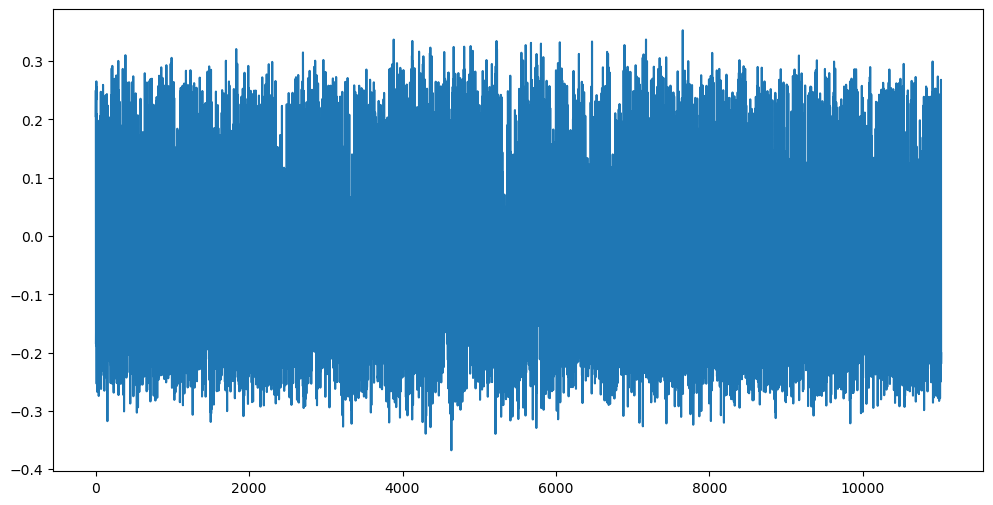

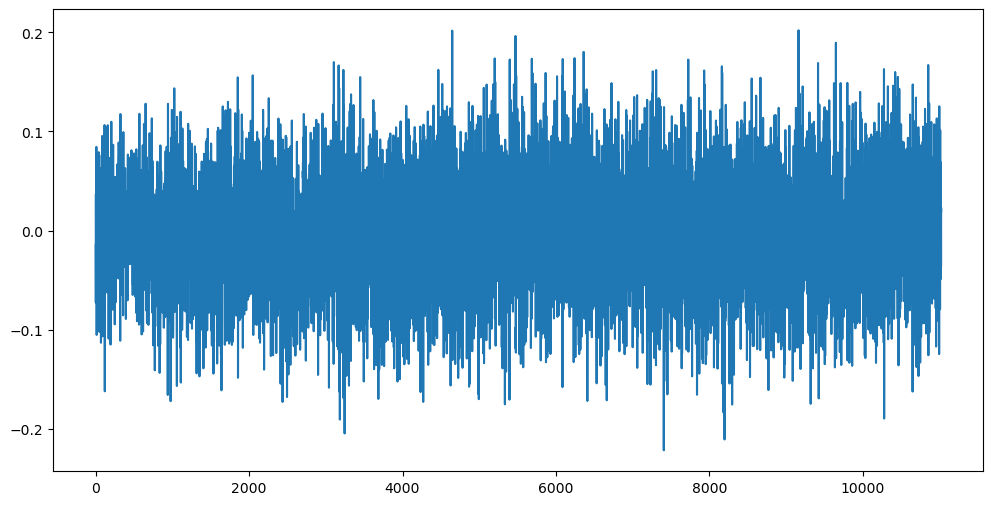

In [12]:
noise = np.random.normal(0,0.05, (1, AUDIO_COLS))
fake_audios = generator.predict(noise)
reshaped_fake_audio = np.reshape(fake_audios, AUDIO_COLS)

stftdata = librosa.stft(reshaped_fake_audio)
glAudio = librosa.griffinlim(stftdata)

#first sample
plt.figure(figsize=(12, 6))
plt.plot(reshaped_fake_audio[0:11025])

#first sample - griffin-lim
plt.figure(figsize=(12, 6))
plt.plot(glAudio[0:11025])

In [13]:
sf.write("cc5g1d1gen.wav", reshaped_fake_audio, 11025)
sf.write("cc5g1d1gl.wav", glAudio, 11025)

RuntimeError: Error opening 'cc5g1d1gen.wav': System error.